In [81]:
#getting and working with data
import pandas as pd
import numpy as np
import re
import os
import datetime as dt
import string

import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import ssm
from ssm.util import find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap

#visualizing results
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)


# Speficy whether or not to save figures
save_figures = False

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 15000)
pd.set_option('display.max_colwidth', -1)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

import transitionMatrix as tm
from transitionMatrix import source_path
#from transitionMatrix.estimators import aalen_johansen_estimator as aj
from transitionMatrix.estimators import cohort_estimator as es

dataset_path = source_path + "datasets/"

In [38]:
path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/data_comb/data_comb_1m_suc.csv'

data = pd.read_csv(path)
data = pd.DataFrame(data = data)
print(data.shape)
data.head()

(95805, 51)


,Unnamed: 0,Round,Round_info,Sub_round,Timepoint,Cage_N,Cage,Animal,Injury,IdRFID,weight_pre,weight_post,weight_diff,notes,wes_day,wd_day,r_day,index,Cage_VDM,Cohort,TP,StartDate,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,ld_seg,RFID_eventDuration,RFID_assign_id_pre,RFID_assign_var_pre,RFID_datetime_start_pre,RFID_datetime_end_pre,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,ld,VDM_RFID_timediff,day_count,min_count,sec_count,hour_count_running,min_count_running,sec_count_running
0,0,sucrose1,post-PET,1,1,3,3,1188,sham,041A555E76,32.5,34.9,1.073846,NaN,NaN,15.0,20.0,7,3,r2,1m,210319,03/20/21 04:32:44,VDM_EtOH10,0.021,2021-03-20 04:32:44,1.616215e+09,2021-03-20,20,04:32:44,4,32,44,dark_am,5.219,041A555E76,AM1-9,2021-03-20 03:10:09.341961600,2021-03-20 03:10:14.560961600,2021-03-20 05:18:17.624016000,041A555E76,same,7683.063054,dark_night1,4949.439038,2,272,16364,28,1712,102704
1,1,sucrose1,post-PET,1,1,3,3,1188,sham,041A555E76,32.5,34.9,1.073846,NaN,NaN,15.0,20.0,37,3,r2,1m,210319,03/21/21 11:38:45,VDM_EtOH10,0.021,2021-03-21 11:38:45,1.616327e+09,2021-03-21,21,11:38:45,11,38,45,light,3.462,041A555E76,AM1-9,2021-03-21 09:31:32.006985600,2021-03-21 09:31:35.468985600,2021-03-21 11:56:48.500966400,041A5553DC,diff,8713.031980,light_day3,7629.531014,3,698,41925,59,3578,214665
2,2,sucrose1,post-PET,1,1,3,3,1188,sham,041A555E76,32.5,34.9,1.073846,NaN,NaN,15.0,20.0,41,3,r2,1m,210319,03/21/21 16:09:28,VDM_EtOH10,0.021,2021-03-21 16:09:28,1.616343e+09,2021-03-21,21,16:09:28,16,9,28,light,3.534,041A555E76,AM1-9,2021-03-21 13:00:09.809020800,2021-03-21 13:00:13.343020800,2021-03-21 17:28:17.923008000,041A5553DC,diff,16084.579987,light_day3,11354.656979,3,969,58168,64,3849,230908
3,3,sucrose1,post-PET,1,1,3,3,1188,sham,041A555E76,32.5,34.9,1.073846,NaN,NaN,15.0,20.0,58,3,r2,1m,210319,03/22/21 10:23:52,VDM_EtOH10,0.021,2021-03-22 10:23:52,1.616409e+09,2021-03-22,22,10:23:52,10,23,52,light,0.958,041A555E76,AM1-9,2021-03-22 09:08:42.986976000,2021-03-22 09:08:43.944976000,2021-03-22 13:19:56.645990400,041A5553DC,diff,15072.701014,light_day4,4508.055024,4,623,37432,82,4943,296572
4,4,sucrose1,post-PET,1,1,3,3,1188,sham,041A555E76,32.5,34.9,1.073846,NaN,NaN,15.0,20.0,98,3,r2,1m,210319,03/24/21 03:25:55,VDM_EtOH10,0.021,2021-03-24 03:25:55,1.616556e+09,2021-03-24,24,03:25:55,3,25,55,dark_am,4.630,041A555E76,AM1-9,2021-03-24 03:18:41.775004800,2021-03-24 03:18:46.405004800,2021-03-24 03:39:23.567990399,041A5552E4,diff,1237.162985,dark_night5,428.594995,6,205,12355,123,7405,444295


In [108]:
data_short = data[data['Animal']==1196]
data_short = data_short[data_short['VDM_RFID_timediff']<2]
data_short = data_short[data_short['VDM_hour']==20]
print(data_short.shape)

(470, 51)


### 1 Simple HMM Demo.ipynb

In [ ]:
# Set the parameters of the HMM
time_bins = 10   # number of time bins
num_states = 4    # number of discrete states
obs_dim = 2       # dimensionality of observation

# Make an HMM
true_hmm = ssm.HMM(num_states, obs_dim, observations="gaussian")

true_states, obs = true_hmm.sample(time_bins)
data = obs # Treat observations generated above as synthetic data.
N_iters = 50

## testing the constrained transitions class
hmm = ssm.HMM(num_states, obs_dim, observations="gaussian")

hmm_lls = hmm.fit(obs, method="em", num_iters=N_iters, init_method="kmeans")

### Intake data

In [27]:
path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/data_comb/data_comb_1m_suc.csv'

data = pd.read_csv(path)
data = pd.DataFrame(data = data)
print(data.shape)
data.sort_values(['IdRFID', 'VDM_second_count']).tail()

(25151, 38)


,Unnamed: 0,Cage,Animal,Injury,IdRFID,weight_pre,index,Cage_VDM,Cohort,TP,StartDate,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,ld_seg,RFID_eventDuration,RFID_assign_id_pre,RFID_assign_var_pre,RFID_datetime_start_pre,RFID_datetime_end_pre,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,ld,VDM_RFID_timediff,VDM_day_count,VDM_hour_count,VDM_min_count,VDM_second_count
24659,24659,4,NaN,blast,041A55602C,30.0,16596,4,r2,1m,210319,03/28/21 23:33:34,VDM_Suc2,0.021,2021-03-28 23:33:34,1.616974e+09,2021-03-28,28,23:33:34,23,33,34,dark_pm,69.479,041A55602C,AM1-14,2021-03-28 23:33:26.341977600,2021-03-28 23:34:35.820977600,2021-03-28 23:34:37.226006400,041A55602C,same,1.405028,dark_night10,0.00000,15,359,21513,1290754
24660,24660,4,NaN,blast,041A55602C,30.0,16606,4,r2,1m,210319,03/28/21 23:37:30,VDM_Suc2,0.021,2021-03-28 23:37:30,1.616975e+09,2021-03-28,28,23:37:30,23,37,30,dark_pm,11.839,041A55602C,AM1-14,2021-03-28 23:37:26.888044800,2021-03-28 23:37:38.727044800,2021-03-28 23:37:40.556006400,041A55602C,same,1.828961,dark_night10,0.00000,15,359,21517,1290990
24661,24661,4,NaN,blast,041A55602C,30.0,16607,4,r2,1m,210319,03/28/21 23:37:41,VDM_Suc2,0.021,2021-03-28 23:37:41,1.616975e+09,2021-03-28,28,23:37:41,23,37,41,dark_pm,6.893,041A55602C,AM1-14,2021-03-28 23:37:40.556006400,2021-03-28 23:37:47.449006400,2021-03-28 23:42:07.183987200,041A555EA7,diff,259.734980,dark_night10,0.00000,15,359,21517,1291001
24662,24662,4,NaN,blast,041A55602C,30.0,16631,4,r2,1m,210319,03/28/21 23:43:42,VDM_Suc2,0.021,2021-03-28 23:43:42,1.616975e+09,2021-03-28,28,23:43:42,23,43,42,dark_pm,1.788,041A55602C,AM1-14,2021-03-28 23:43:39.642009600,2021-03-28 23:43:41.430009600,2021-03-28 23:43:42.984998400,041A55602C,same,1.554988,dark_night10,0.56999,15,359,21523,1291362
24663,24663,4,NaN,blast,041A55602C,30.0,16660,4,r2,1m,210319,03/28/21 23:52:42,VDM_Suc2,0.021,2021-03-28 23:52:42,1.616976e+09,2021-03-28,28,23:52:42,23,52,42,dark_pm,6.796,041A55602C,AM1-14,2021-03-28 23:52:37.668979200,2021-03-28 23:52:44.464979200,2021-03-28 23:55:18.639004800,041A55602C,same,154.174025,dark_night10,0.00000,15,359,21532,1291902


In [29]:
data_int['variable'].value_counts()

VDM_H20       2520
VDM_Suc2      1742
VDM_EtOH10    41  
VDM_EtOH20    32  
Name: variable, dtype: int64

In [31]:
data_int = data[data['VDM_day_count']<8]
day_max = data_int['VDM_day_count'].max()

sec_in_day = 60*60*24*day_max
print(sec_in_day)

final_data = pd.DataFrame(data=np.linspace(0, sec_in_day-1, num=sec_in_day), columns=['time'])
print(final_data.shape)

x= data_int[data_int['IdRFID']=='041A555DEE'][['VDM_second_count', 'variable']]
y= data_int[data_int['IdRFID']=='041A5552E4'][['VDM_second_count', 'variable']]
z= data_int[data_int['IdRFID']=='041A555FA3'][['VDM_second_count', 'variable']]
final_data_merge = final_data.merge(x, how='left', left_on='time', right_on='VDM_second_count')
final_data_merge = final_data_merge.merge(y, how='left', left_on=['time'], right_on='VDM_second_count')
final_data_merge = final_data_merge.merge(z, how='left', left_on=['time'], right_on='VDM_second_count')
final_data_merge = final_data_merge.replace({np.nan:'none'})
print(final_data_merge.shape)

state_map = {'none': 0,
             'VDM_H20': 1,
             'VDM_Suc2': 2,
             'VDM_EtOH10': 3,
             'VDM_EtOH20': 4}

final_data_merge['From1'] = final_data_merge['variable_x'].map(state_map)
final_data_merge['From2'] = final_data_merge['variable_y'].map(state_map)
final_data_merge['From3'] = final_data_merge['variable'].map(state_map)

obs = final_data_merge[['From1', 'From2', 'From3']].to_numpy()

obs

604800
(604800, 1)
(604801, 7)


array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       ...,
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])

  0%|          | 0/5 [00:00<?, ?it/s]

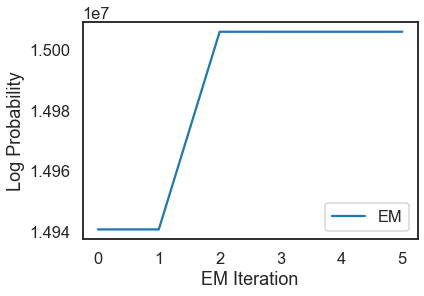

In [6]:
# Set the parameters of the HMM
time_bins = len(obs)  # number of time bins
num_states = 5    # number of discrete states - how many bottles
obs_dim = 3       # dimensionality of observation - how many animals

N_iters = 5

# Make an HMM
hmm = ssm.HMM(num_states, obs_dim, observations="gaussian")
hmm_lls = hmm.fit(obs, method="em", num_iters=N_iters, init_method="kmeans")

plt.plot(hmm_lls, label="EM")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")
plt.show()

# Find a permutation of the states that best matches the true and inferred states
most_likely_states = hmm.most_likely_states(obs)


In [7]:
most_likely_states

array([0, 0, 0, ..., 0, 0, 0])

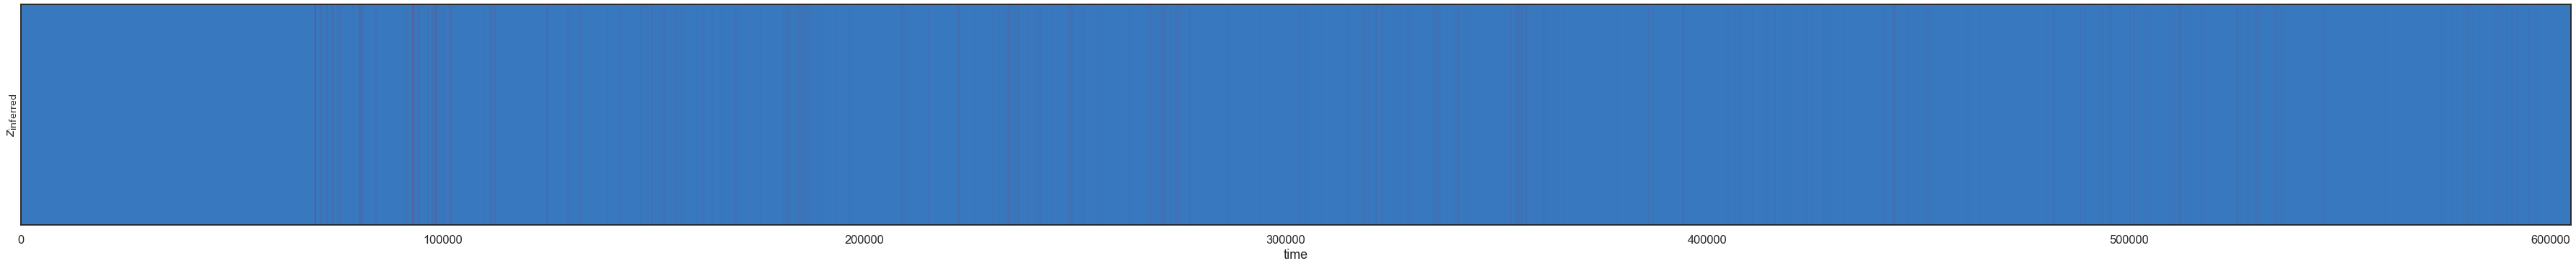

In [12]:
plt.figure(figsize=(50, 10))

plt.subplot(212)
plt.imshow(most_likely_states[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, time_bins)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

plt.tight_layout()

Text(0.5, 0, 'time')

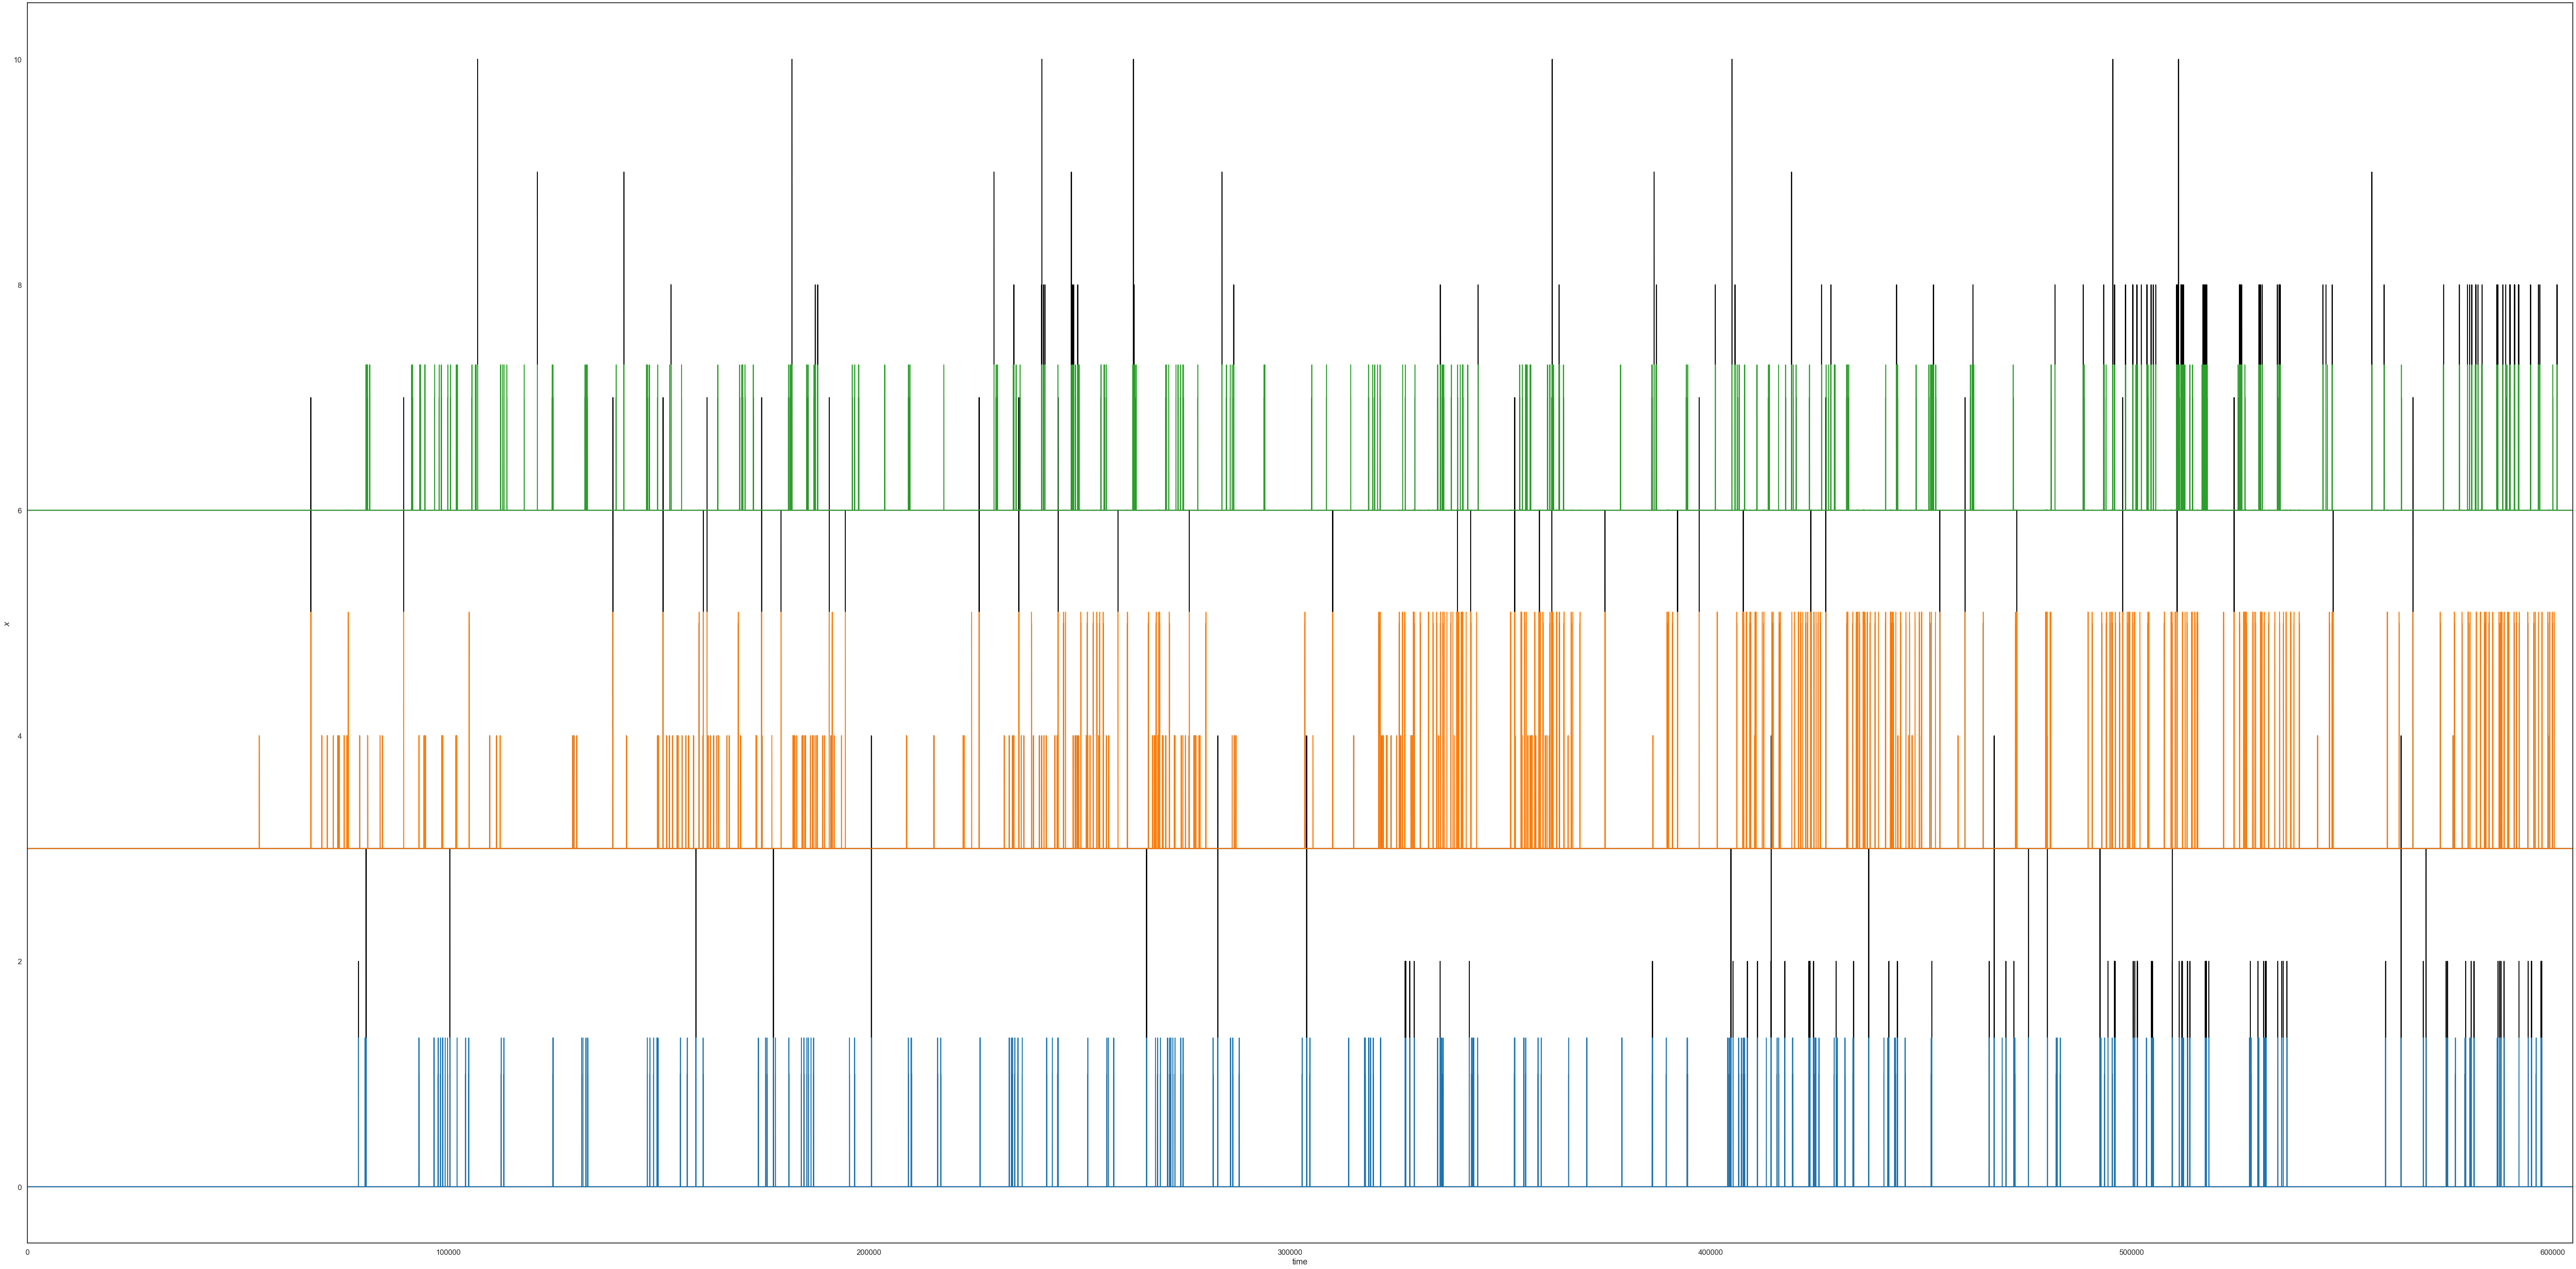

In [13]:
# Use the HMM to "smooth" the data
hmm_x = hmm.smooth(obs)

plt.figure(figsize=(100, 50))
plt.plot(obs + 3 * np.arange(obs_dim), '-k', lw=2)
plt.plot(hmm_x + 3 * np.arange(obs_dim), '-', lw=2)
plt.xlim(0, time_bins)
plt.ylabel("$x$")
# plt.yticks([])
plt.xlabel("time")

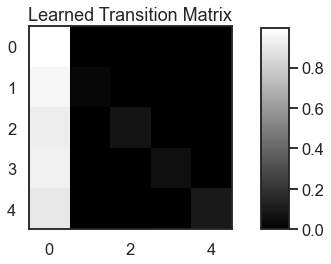

In [14]:
learned_transition_mat = hmm.transitions.transition_matrix

fig = plt.figure(figsize=(8, 4))
plt.subplot(122)
im = plt.imshow(learned_transition_mat, cmap='gray')
plt.title("Learned Transition Matrix")

cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

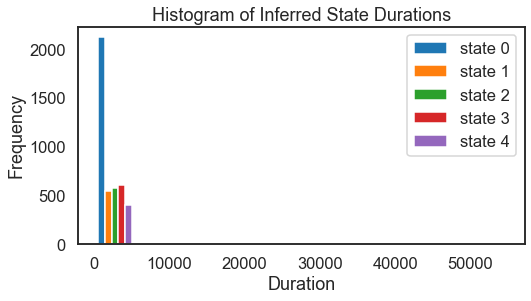

In [15]:
inferred_state_list, inferred_durations = ssm.util.rle(most_likely_states)

# Rearrange the lists of durations to be a nested list where
# the nth inner list is a list of durations for state n

inf_durs_stacked = []
for s in range(num_states):
    inf_durs_stacked.append(inferred_durations[inferred_state_list == s])
    
fig = plt.figure(figsize=(8, 4))
plt.hist(inf_durs_stacked, label=['state ' + str(s) for s in range(num_states)])
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.legend()
plt.title('Histogram of Inferred State Durations')

plt.show()

In [ ]:
state_map = {'VDM_H20': 0,
             'VDM_05_etoh': 1,
             'VDM_10_etoh': 2,
             'VDM_20_etoh': 3}

data_1028 = data_RFID[data_RFID['Animal']==1028]

data_1028['From'] = data_1028['variable'].map(state_map)

data_1028['From'].shape

In [ ]:
# Set the parameters of the HMM
time_bins = 10  # number of time bins
num_states = 4    # number of discrete states - how many bottles
obs_dim = 1       # dimensionality of observation - how many animals

N_iters = 50

# Make an HMM
hmm = ssm.HMM(num_states, obs_dim, observations="gaussian")
hmm_lls = hmm.fit(np.array(prac), method="em", num_iters=N_iters, init_method="kmeans")


In [ ]:
# Set the parameters of the HMM
time_bins = 1000 # number of time bins
num_states = 5    # number of discrete states
obs_dim = 1    # data dimension
input_dim = 2    # input dimension
num_categories = 3    # number of output types/categories
np.sin(2 * np.pi * np.arange(time_bins) / 50)[:, None] + 1e-1 * npr.randn(time_bins, input_dim)


In [ ]:
# Set the parameters of the HMM
time_bins = 10   # number of time bins
num_states = 5    # number of discrete states - how many bottles
obs_dim = 1       # dimensionality of observation - how many animals

# Make an HMM
true_hmm = ssm.HMM(num_states, obs_dim, observations="gaussian")

# Manually tweak the means to make them farther apart
#thetas = np.linspace(0, 2 * np.pi, num_states, endpoint=False)
#true_hmm.observations.mus = 3 * np.column_stack((np.cos(thetas), np.sin(thetas)))

In [ ]:

# Sample some data from the HMM
true_states, obs = true_hmm.sample(time_bins)
#true_ll = true_hmm.log_probability(obs)
obs

In [ ]:
T = 100  # number of time bins
K = 5    # number of discrete states
D = 2    # dimension of the observations

# make an hmm and sample from it
hmm = ssm.HMM(K, D, observations="gaussian")
z, y = hmm.sample(T)

test_hmm = ssm.HMM(K, D, observations="gaussian")
test_hmm.fit(y)
zhat = test_hmm.most_likely_states(y)
zhat

In [ ]:
data_1028['variable'].value_counts()

In [ ]:

data = obs # Treat observations generated above as synthetic data.
N_iters = 50

## testing the constrained transitions class
hmm = ssm.HMM(num_states, obs_dim, observations="gaussian")

hmm_lls = hmm.fit(obs, method="em", num_iters=N_iters, init_method="kmeans")


In [ ]:
data

In [ ]:
data_RFID_short = data_RFID[['Animal', 'min_count', 'unitLabel_drink']]
data_RFID_short.columns = ['ID', 'Time', 'From']

state_map = {'RFID_10': 0,
             'RFID_20': 1,
             'RFID_05': 2,
             'RFID_H20': 3}

data_RFID_short['From'] = data_RFID_short['From'].map(state_map)

print(data_RFID_short.shape)
data_RFID_short.head()

In [ ]:
mouse_999 = data_RFID_short[data_RFID_short['ID'] == 999]
sorted_data = mouse_999.sort_values(['ID', 'Time'], ascending=[True, True])
sorted_data['To'] = sorted_data['From'].shift(-1)
sorted_data.dropna(inplace=True)
definition = [('0', "A"), ('1', "B"), ('2', "C"), ('3', "D")]
myState = tm.StateSpace(definition)
myState.describe()

# We validate that indeed the data set conforms to our expectations
labels = {'State': 'From'}
print('From', myState.validate_dataset(dataset=sorted_data, labels=labels))
labels = {'State': 'To'}
print('To', myState.validate_dataset(dataset=sorted_data, labels=labels))

sorted_data.head()

In [ ]:
myEstimator = aj.AalenJohansenEstimator(states=myState)
labels = {'Timestamp': 'Time', 'From_State': 'From', 'To_State': 'To', 'ID': 'ID'}
etm, times = myEstimator.fit(sorted_data, labels=labels)

In [ ]:
example = 1

# Step 1
# Load the data set into a pandas frame
# Make sure state is read as a string and not as integer
# Second synthetic data example:
# n entities with ~10 observations each, [0,1] state, 50%/50% transition matrix
print("> Step 1: Load the data set into a pandas frame")
if example == 1:
    data = pd.read_csv(dataset_path + 'synthetic_data7.csv', dtype={'State': str})
elif example == 2:
    data = pd.read_csv(dataset_path + 'synthetic_data8.csv', dtype={'State': str})
elif example == 3:
    data = pd.read_csv(dataset_path + 'synthetic_data9.csv', parse_dates=True)
    # convert datetime data to floats, return also the observation window data
    bounds, data = datetime_to_float(data)
    print('Start and End dates', bounds)

sorted_data = data.sort_values(['Time', 'ID'], ascending=[True, True])
print(sorted_data.head(5))
print(sorted_data.describe())
# Step 2
# Describe and validate the State Space against the data
print("> Step 2: Describe and validate the State Space against the data")
# We insert the expected labels of the state space
if example == 1 or example == 3:
    definition = [('0', "AAA"), ('1', "AA"), ('2', "A"), ('3', "BBB"),
                  ('4', "BB"), ('5', "B"), ('6', "CCC"), ('7', "D")]
elif example == 2:
    definition = [('0', "G"), ('1', "B")]
myState = tm.StateSpace(definition)
myState.describe()
# We validate that indeed the data set conforms to our expectations
labels = {'State': 'From'}
print(myState.validate_dataset(dataset=sorted_data, labels=labels))
labels = {'State': 'To'}
print(myState.validate_dataset(dataset=sorted_data, labels=labels))

print("> Step 3: Estimate matrices using the Aalen-Johansen estimator")
myEstimator = aj.AalenJohansenEstimator(states=myState)
labels = {'Timestamp': 'Time', 'From_State': 'From', 'To_State': 'To', 'ID': 'ID'}
etm, times = myEstimator.fit(sorted_data, labels=labels)

In [ ]:
data_RFID_short = data_RFID[['Animal', 'min_count', 'unitLabel_drink']]
data_RFID_short.columns = ['ID', 'Time', 'State']
sorted_data = data_RFID_short.sort_values(['ID', 'Time'], ascending=[True, True])
myState = tm.StateSpace([('RFID_10', "A"), ('RFID_20', "B"), ('RFID_05', "C"), ('RFID_H20', "D")])
print(myState.validate_dataset(dataset=sorted_data))

print("> Step 3: Estimate matrices using the Aalen-Johansen estimator")
myEstimator = aj.AalenJohansenEstimator(states=myState)
labels = {'Timestamp': 'Time', 'From_State': 'From', 'To_State': 'To', 'ID': 'ID'}
etm, times = myEstimator.fit(sorted_data, labels=labels)


In [ ]:
data_RFID_short = data_RFID[['Animal', 'min_count', 'unitLabel_drink']]
data_RFID_short.columns = ['ID', 'Time', 'State']

state_map = {'RFID_H20': 0,
             'RFID_05': 1,
             'RFID_10': 2,
             'RFID_20': 3}

data_RFID_short['State'] = data_RFID_short['State'].map(state_map)

sorted_data = data_RFID_short.sort_values(['ID', 'State'], ascending=[True, True])


cohort_data, cohort_intervals = tm.utils.bin_timestamps(data_RFID_short, cohorts=5)
myEstimator = es.CohortEstimator(states=myState, ci={'method': 'goodman', 'alpha': 0.05})
labels = {'Timestamp': 'Cohort', 'State': 'State', 'ID': 'ID'}
result = myEstimator.fit(cohort_data, labels=labels)
myMatrixSet = tm.TransitionMatrixSet(values=result, temporal_type='Incremental')
myMatrixSet.print_matrix()

In [ ]:
result

In [ ]:
myState = tm.StateSpace([(0, "A"),
                         (1, "B"),
                         (2, "C"),
                         (3, "D")])
myState.describe()
print(myState.validate_dataset(dataset=sorted_data))

cohort_data, cohort_intervals = tm.utils.bin_timestamps(data_RFID_short, cohorts=5)

myEstimator = es.CohortEstimator(states=myState, ci={'method': 'goodman', 'alpha': 0.05})
labels = {'Timestamp': 'Cohort', 'State': 'State', 'ID': 'ID'}
result = myEstimator.fit(cohort_data, labels=labels)

In [ ]:
example = 2

if example == 2:

    # Step 1
    # Load the data set into a pandas frame
    # Make sure state is read as a string and not as integer
    # Second synthetic data example:
    # n entities with ~10 observations each, [0,1] state, 50%/50% transition matrix
    print("> Step 1: Load the data")
    data = pd.read_csv(dataset_path + 'synthetic_data2.csv', dtype={'State': str})
    sorted_data = data.sort_values(['ID', 'Time'], ascending=[True, True])
    print(sorted_data.describe())

    # Step 2
    # Describe and validate the State Space against the data
    print("> Step 2: Validate against state space")
    myState = tm.StateSpace([('0', "Basic"), ('1', "Default")])
    myState.describe()
    print(myState.validate_dataset(dataset=sorted_data))

    # Step 3
    # Arrange the data in period cohorts
    print("> Step 3: Arrange the data in period cohorts")
    cohort_data, cohort_intervals = tm.utils.bin_timestamps(data, cohorts=5)

    # Step 4
    # Estimate matrices using method of choice
    # compute confidence interval using goodman method at 95% confidence level
    print("> Step 4: Estimate matrices")
    myEstimator = es.CohortEstimator(states=myState, ci={'method': 'goodman', 'alpha': 0.05})
    labels = {'Timestamp': 'Cohort', 'State': 'State', 'ID': 'ID'}
    result = myEstimator.fit(cohort_data, labels=labels)

    # Step 5
    # Print out the set of estimated matrices
    print("> Step 5: Display results")
    myMatrixSet = tm.TransitionMatrixSet(values=result, temporal_type='Incremental')
    print(myMatrixSet.temporal_type)
    myMatrixSet.print_matrix